In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
sns.set_theme(style="darkgrid")
figsize(10, 6)
pd.set_option('display.max_colwidth', -1)


/var/folders/0t/rs4xlk9945xdd3cxy6yc9j340000gq/T/ipykernel_55539/3913289642.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def get_indexes(raw):
   if( not pd.isna(raw)):
      highlights = re.findall(r'\d+:', raw)
      return list(map(lambda x: int(x.replace(':', '')) - 1, highlights))

In [73]:
data = pd.read_csv('survey_responses.csv')
data = data.drop(['StartDate', 'ResponseId', 'EndDate', 'IPAddress', 'Progress', 'Duration (in seconds)', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'Q_RecaptchaScore', 'UserLanguage'], axis=1)[data['Finished'] == 'True']
data['highlight_hp_high_1'] = data['highlight_hp_high_1'].map(get_indexes)
data['highlight_hp_high_2'] = data['highlight_hp_high_2'].map(get_indexes)
data['highlight_hp_low_1'] = data['highlight_hp_low_1'].map(get_indexes)
data['highlight_hp_low_2'] = data['highlight_hp_low_2'].map(get_indexes)
data['highlight_hero_high_1'] = data['highlight_hero_high_1'].map(get_indexes)
data['highlight_hero_high_2'] = data['highlight_hero_high_2'].map(get_indexes)
data['highlight_hero_low_1'] = data['highlight_hero_low_1'].map(get_indexes)
data['highlight_hero_low_2'] = data['highlight_hero_low_2'].map(get_indexes)

In [4]:
hp_high_sentences = list(open('hp_high.txt', 'r').read().split('\n'))
hp_low_sentences = list(open('hp_low.txt', 'r').read().split('\n'))
hero_high_sentences = list(open('hero_high.txt', 'r').read().split('\n'))
hero_low_sentences = list(open('hero_low.txt', 'r').read().split('\n'))


In [35]:
def group_highlights(sent, highlights):
   highlight_array = np.zeros(len(sent))
   for x in highlights:
      if(x != None):
         highlight_array[x] += 1
   return highlight_array

In [7]:
def get_highlight_text(sent, bool_array):
   return [sent[i] for i in np.where(bool_array)[0]]

In [74]:
def show_highlight_results(storyName, sentences, data):
   column_inc = f"highlight_{storyName}_1"
   column_dec = f"highlight_{storyName}_2"
   sent_count = len(sentences)
   x = np.linspace(0, sent_count-1, sent_count)
   y1 = group_highlights(sentences, data[column_inc])
   y2 = group_highlights(sentences, data[column_dec])
   plt.scatter(x, y1, alpha=.5, color='b')
   plt.scatter(x, y2, alpha=.5, color='r')
   plt.xlabel("Sentences")
   plt.ylabel("Highlight Count")
   plt.title(f"Highlights for {storyName}")

   plt.show()
   return (y1, y2)

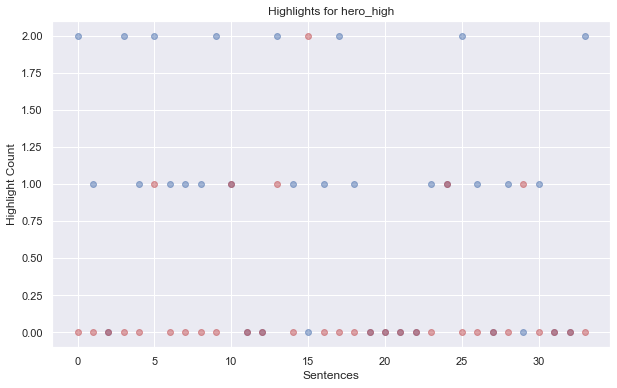

,0,inc,dec
0,"Even after an hour-long shower, Izuku still felt the weight of the past 24 hours clinging to his skin.",2.0,0.0
1,"All Might looked down on him from every wall in his room, judgmental eyes staring straight into his soul.",1.0,0.0
2,You can’t be a hero,0.0,0.0
3,Not without a quirk,2.0,0.0
4,Be realistic,1.0,0.0
5,Izuku went to bed crying for his broken dream.,2.0,1.0
6,His room looked empty without all his All Might merch.,1.0,0.0
7,"It wasn’t that Izuku hated All Might now, it’s just that every time he looked at the smiling hero, all he could think was you can’t be a hero.",1.0,0.0
8,Just because Izuku was finally coming to terms with that fact didn’t mean he needed it playing on a loop in his head every time he’s at home.,1.0,0.0
9,"He still had a few posters up from some of his other favorite heroes, but he’d changed his sheets to a plain black set that he’d found collecting dust in the linen closet paired with a gold pillowcase.",2.0,0.0


In [83]:
counts_inc, counts_dec = show_highlight_results('hero_high', hero_high_sentences, data) # show individual results by passing in a row: data[1:2]
sentence_counts = pd.DataFrame(hero_high_sentences)
sentence_counts['inc'] = counts_inc
sentence_counts['dec'] = counts_dec
display(sentence_counts)

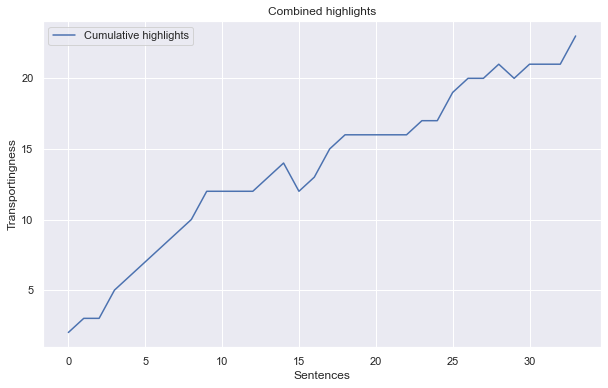

In [84]:
combined_highlights = counts_inc - counts_dec
x = np.linspace(0, len(counts_inc)-1, len(counts_inc))

pdf = combined_highlights
cdf = np.cumsum(pdf)

plt.plot(x, cdf, label="Cumulative highlights")
plt.xlabel("Sentences")
plt.ylabel("Transportingness")
plt.title("Combined highlights")
plt.legend()
plt.show()

In [4]:
questions = pd.read_csv('survey_responses.csv')[0:1]

In [5]:
scale_questions = ['emotional_affect', 'forgetting_surroundings', 'distracted', 'characters_alive', 'mental_imagery']